# Table of Contents

1. [Introduction](#section1)
    - 1.1 [Objective](#section1.1)
    - 1.2 [Dataset Description](#section1.2)
2. [Setup and Configuration](#section2)
    - 2.1 [Import Libraries](#section2.1)
3. [Data Loading](#section3)
    - 3.1 [Load Data from Source](#section3.1)
    - 3.2 [Data Transformation](#section3.2)
    - 3.3 [Macroeconomic Trends](#section3.3)
    - 3.4 [CPI trend](#section3.4)
4. [Univariate Forecasting with LSTM](#section4)
    - 4.1 [LSTM Model Preparation](#section4.1)
    - 4.2 [Test Data Preparation](#section4.2)
    - 4.3 [Cross-Validation Setup for Training Data](#section4.3)
    - 4.4 [Forcaseting](#section4.4)
5. [Conclusion](#section5)
    - 5.1 [Summary of Findings](#section5.1)
6. [References](#section6)

# Introduction

Traditional inflation forecasting models have struggled to outperform simple univariate approaches and in other hand the interpretability of machine learning models, such as neural networks, remains a challenge. Recurrent networks, designed to model sequential data, offer a possible solution due to their ability to learn dynamic dependencies over time.

The project is based on research papers work for inflation forecasting with LSTMs. For more details, see [Fernandes Theoharidis et al., 2021].

## Objective

Our project focuses on forecasting inflation using Long Short-Term Memory (LSTM) models.By analyzing past CPI dynamics and incorporating macroeconomic indicators, the project seeks to improve forecast quality and offer insights into future economic conditions.

## Dataset Description

The project uses fredpy package to get the economic indicators from the Federal Reserve Economic Data (FRED) API.

After installing fredpy via pip (pip install fredpy), we can retrieve a variety of economic time series data.

- **GDP (`GDP`)**: Gross Domestic Product, the total market value of all final goods and services produced within the U.S. in a given period.
- **Consumption (`PCEC`)**: Personal Consumption Expenditures, reflecting consumer spending on goods and services.
- **Investment (`GPDI`)**: Gross Private Domestic Investment, indicating private sector spending on equipment and structures.
- **Government Spending (`GCE`)**: Government Consumption Expenditures and Gross Investment, covering government spending on goods and services as well as infrastructure.
- **Exports (`EXPGS`)**: Exports of Goods and Services, the value of all goods and services the U.S. sells to the rest of the world.
- **Imports (`IMPGS`)**: Imports of Goods and Services, the value of all goods and services the U.S. buys from the rest of the world.
- **Net Exports (`NETEXP`)**: The difference between the value of exports and imports, indicating the trade balance.
- **Hours Worked (`HOANBS`)**: Total hours worked in the business sector, a measure of labor input.
- **GDP Deflator (`GDPDEF`)**: A measure of the price level for all domestic goods and services, indicating inflation within the economy.
- **PCE Deflator (`PCECTPI`)**: Personal Consumption Expenditures Price Index, a measure of inflation for consumer goods and services.
- **CPI (`CPIAUCSL`)**: Consumer Price Index, reflecting the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services.
- **M2 Money Supply (`M2SL`)**: Represents the total amount of money supply. It's a broad measure of the economy's liquidity.
- **3-Month Treasury Bill Rate (`TB3MS`)**: short-term interest rate set by the demand for U.S. Treasury bills, which are considered risk-free.
- **Unemployment Rate (`UNRATE`)**: Measures the percentage of the total workforce that is unemployed and actively seeking employment during the previous month.



# Setup and Configuration
## Import Libraries


In [27]:
pip install fredpy

In [28]:
import pandas as pd
import random
import numpy as np
import fredpy as fp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pickle
import csv
from dateutil.relativedelta import relativedelta

random.seed(123)

images = "/content/images/"
export_path = "/content/"
fred_api_key = 'fred_api_key.txt'

# 3. Data Loading
## 3.1 Load Data from FED API

In [29]:
# Load FRED API key
#fp.api_key = fp.load_api_key(fred_api_key)
fp.api_key = 'b4d6af7b7bad0a8d676f184880ab6b3a'

In [30]:
gdp = fp.series('GDP')
consumption = fp.series('PCEC')
investment = fp.series('GPDI')
government = fp.series('GCE')
exports = fp.series('EXPGS')
imports = fp.series('IMPGS')
net_exports = fp.series('NETEXP')
hours = fp.series('HOANBS')
deflator = fp.series('GDPDEF')
pce_deflator = fp.series('PCECTPI')
cpi = fp.series('CPIAUCSL')
m2 = fp.series('M2SL')
tbill_3mo = fp.series('TB3MS')
unemployment = fp.series('UNRATE')

## 3.2 Data Transformation

In [31]:
# Extracting base years for CPI and NIPA deflators for reference
cpi_base_year = cpi.units.split(' ')[1].split('=')[0]  # Extract CPI base year
nipa_base_year = deflator.units.split(' ')[1].split('=')[0]  # Extract NIPA base year

# Converting monthly economic data series to quarterly for consistency
m2 = m2.as_frequency('Q')  # Convert M2 money supply to quarterly
tbill_3mo = tbill_3mo.as_frequency('Q')  # Convert 3-month T-Bill rates to quarterly
unemployment = unemployment.as_frequency('Q')  # Convert unemployment rates to quarterly
#cpi = cpi.as_frequency('Q')  # Convert CPI to quarterly

# Adjust economic series for inflation and calculate annual percent change
def deflate(series, deflator):
    deflator, series = fp.window_equalize([deflator, series])  # Equalize series windows
    series = series.divide(deflator).times(100)  # Adjust series for inflation
    return series

pce_deflator = pce_deflator.apc()  # Annual percent change in PCE inflation
cpi = cpi.apc()  # Annual percent change in CPI inflation
deflator = deflator.apc()  # Annual percent change in GDP deflator inflation

# Normalize rates to decimal form for analysis
unemployment = unemployment.divide(100)
tbill_3mo = tbill_3mo.divide(100)
pce_deflator = pce_deflator.divide(100)
cpi = cpi.divide(100)
deflator = deflator.divide(100)

# Adjust 3-month T-Bill series time window for relevance
tbill_3mo = tbill_3mo.window([gdp.data.index[0], '2222'])  # Focus T-Bill data on relevant period

## 3.3 Macroeconomic Trends

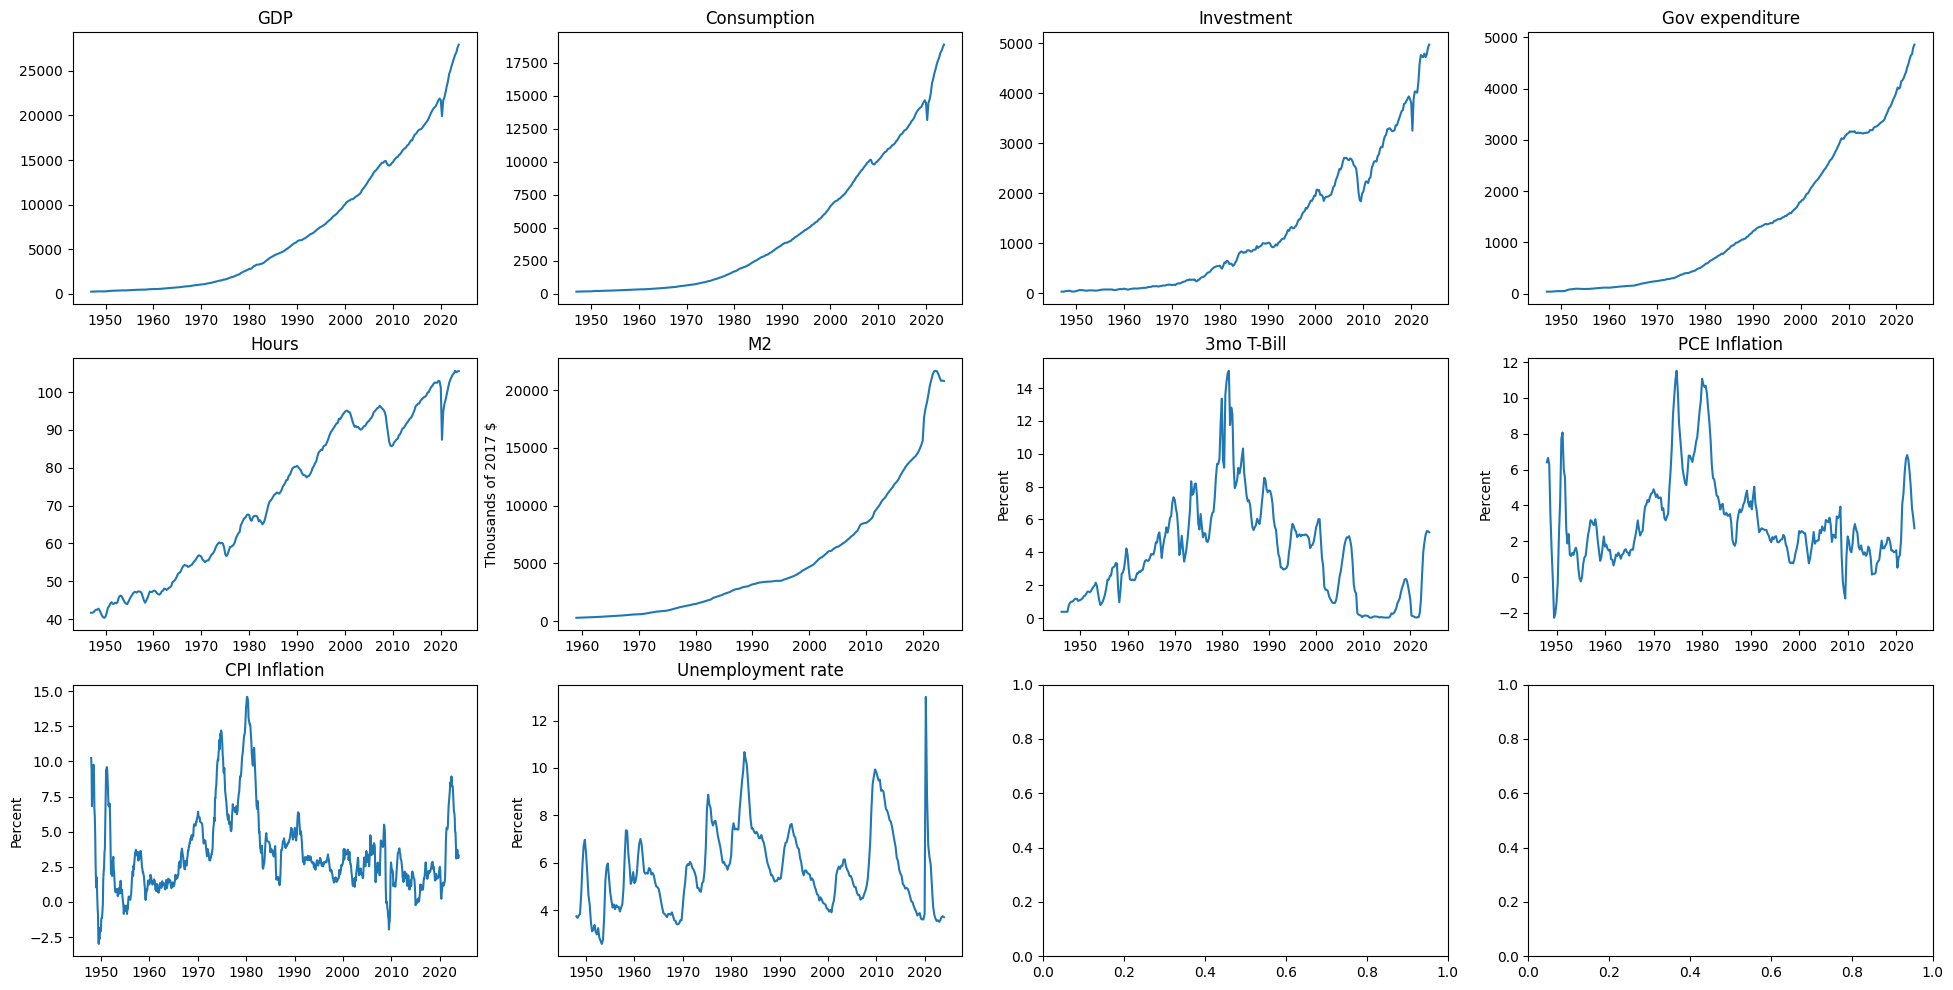

In [32]:
fig, axes = plt.subplots(3,4,figsize=(6*4,4*3))

axes[0][0].plot(gdp.data)
axes[0][0].set_title('GDP')
axes[0][0].set_ylabel('')

axes[0][1].plot(consumption.data)
axes[0][1].set_title('Consumption')
axes[0][1].set_ylabel('')

axes[0][2].plot(investment.data)
axes[0][2].set_title('Investment')
axes[0][2].set_ylabel('')

axes[0][3].plot(government.data)
axes[0][3].set_title('Gov expenditure')
axes[0][3].set_ylabel('')

axes[1][0].plot(hours.data)
axes[1][0].set_title('Hours')
axes[1][0].set_ylabel('')

axes[1][1].plot(m2.data)
axes[1][1].set_title('M2')
axes[1][1].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][2].plot(tbill_3mo.data*100)
axes[1][2].set_title('3mo T-Bill')
axes[1][2].set_ylabel('Percent')

axes[1][3].plot(pce_deflator.data*100)
axes[1][3].set_title('PCE Inflation')
axes[1][3].set_ylabel('Percent')

axes[2][0].plot(cpi.data*100)
axes[2][0].set_title('CPI Inflation')
axes[2][0].set_ylabel('Percent')

axes[2][1].plot(unemployment.data*100)
axes[2][1].set_title('Unemployment rate')
axes[2][1].set_ylabel('Percent');

The graphs presents long-term trends in various economic indicators. We see a general increase in GDP, consumption, investment, and government expenditure, indicating economic growth over time. Hours worked have also risen, suggesting a growing labor input. The money supply, shown as M2, has seen a significant increase, especially in recent years.

In terms of inflation, both CPI and PCE inflation rates have fluctuated, with notable peaks and troughs, reflecting varying economic conditions over the decades. The unemployment rate shows cycles of increase and decrease, typical of economic booms and recessions.

Lastly, the interest rate, represented by the 3mo T-Bill, has experienced highs and lows, which are often aligned with monetary policy responses to economic changes.

## 3.4 CPI trend

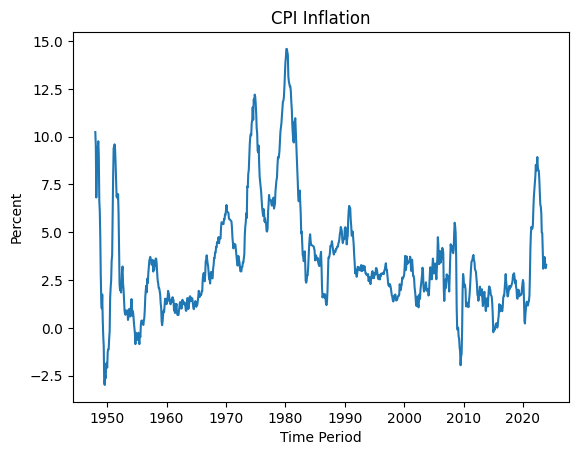

In [33]:
plt.plot(cpi.data*100)
plt.title('CPI Inflation')  # Corrected to plt.title
plt.ylabel('Percent')  # Corrected to plt.ylabel
plt.xlabel('Time Period')  # Assuming you might want to label the x-axis as well
plt.show()

In [34]:
CPI_monthly = pd.DataFrame({'cpi_inflation':cpi.data})
CPI_monthly = CPI_monthly.dropna()
CPI_monthly.to_csv(export_path+'cpi_data.csv')

In [35]:
CPI_monthly = pd.read_csv('/content/cpi_data.csv')

In [36]:
CPI_monthly.shape

(912, 2)

# 4.Univariate Forecasting with LSTM
Univariate forecasting with LSTM involves using a single time series variable's historical data to predict its future values.

LSTM networks manage information flow using several gates and states. Below are the essential components:

**Forget Gate $f_t$:** Determines the information to discard from the cell state.
   - Formula: $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)\$

**Input Gate $i_t$ and Candidate Layer $\tilde{C}_t$:** Decides what new information to add to the cell state.
   - Formula: $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - Formula: $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

**Update Cell State $C_t$:** Updates the cell state to the new state, incorporating the new information.
   - Formula: $C_t = f_t \ast C_{t-1} + i_t \ast \tilde{C}_t$

**Output Gate $o_t$and Hidden State $h_t$:** Determines the next hidden state based on the cell state and the output gate's output.
   - Formula: $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
   - Formula: $h_t = o_t \ast \tanh(C_t)$

Where:
- $\sigma$: Sigmoid function, outputs between 0 and 1.
- $\tanh$: Hyperbolic tangent function, outputs between -1 and 1.
- \(W\), \(b\): Weights and biases for the gates.
- $[h_{t-1}, x_t]$: Concatenation of the previous hidden state and the current input.
- $\ast$: Element-wise multiplication.

These mechanisms allow LSTMs to effectively learn and make predictions for univariate time series forecasting by carefully regulating the information that is kept or discarded throughout the learning process.

## 4.1 LSTM Model Preparation
Thee data preparation and scaling steps involve converting the CPI monthly date
column to a datetime format for proper handling, and normalizing CPI inflation data using MinMaxScaler.
For LSTM preparation, the process defines a 20-lag period for input features, reserves the last 20 observations for out-of-sample testing, and transforms the time series into a supervised learning problem by creating sequences of past values as inputs to predict future values.

In [37]:
CPI_monthly['date'] = pd.to_datetime(CPI_monthly['date'])
# scale all the data between 0 and 1
scaler = MinMaxScaler()
scaled_CPI = np.asarray(CPI_monthly['cpi_inflation']).reshape(-1, 1)

# the number of lags we will consider here (will consider other lags: p = [24,20,19,14,12])
p = 20

# print(scaled_CPI.shape)
lenght = CPI_monthly.shape[0]

last1 = [ele for ele in scaled_CPI[lenght-p:, 0].tolist()]
with open(export_path+"/last20data.csv", "w") as f:
    wr = csv.writer(f, delimiter="\n")
    wr.writerow(['Data'])
    wr.writerow(last1)

scaled_CPI = scaler.fit_transform(scaled_CPI)

In [38]:
# We omit the last 20 observations for our out of sample forecast
out_of_sample_forecast_input = scaled_CPI[lenght-p:, 0]

# Retain all the data minus the last 20 observatinos for forecasting
scaled_CPI = scaled_CPI[:lenght-p, 0]

In [39]:
# Functions transforms our time series sequence into a supervised leaning problem
def split_sequences(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence) - (n_steps_in + n_steps_out)):
        append_X = []
        append_y = []
        for j in range(n_steps_in):
            append_X.append(sequence[i + j])
        for k in range(n_steps_out):
            append_y.append(sequence[i + n_steps_in + k + 1])

        X.append(append_X)
        y.append(append_y)

    return np.array(X), np.array(y)

## 4.2 Test Data Preparation

In [40]:
# n_steps_in = number of lags we consider
# n-_steps_out = number of periods to forecast
X, y = split_sequences(scaled_CPI, n_steps_in=20, n_steps_out=12)

In [41]:
# Let's obtain our test data, which is +-10 % of our remaining time series:
# We want the order of our sequences of observations for the test data to be random with respect to time, so:
# sample randomly 90 values between 1 and 892
n_steps_in = 20
# we only consider as input lagged CPI for now, so n_features = 1
n_features = 1
n_steps_out = 12
# n_steps_in = number of lags we consider
# n-_steps_out = number of periods to forecast
X, y = split_sequences(scaled_CPI, n_steps_in=20, n_steps_out=12)


    # Obtain 86 sequential data points for test (10%)
    # we dropped the assumption that inflation was time invariant,
    # so we want our data to train on the closest data to the ones put in the forecast.
    # Thus the test data will be the first 10% of the data

X_train = X[0:lenght-p-n_steps_in-n_steps_out]
X_test = X[lenght-p-n_steps_in-n_steps_out:]
y_train = y[0:lenght-p-n_steps_in-n_steps_out]
y_test = y[lenght-p-n_steps_in-n_steps_out:]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], n_features)

## 4.2 Cross-Validation Setup for Training Data

To optimize our LSTM model, we divided our data into 10% for testing, 10% for validation, and 80% for training. In this section we will use Monte Carlo cross-validation to iteratively refine the model.
The validation set is our instrument to choose the best set of
hyperparameter values. In our LSTM model, the hyperparameters to consider are the start date of our time series, the number of epochs, the lag-length for each input (batch size), the learning rate for gradient descent, the activation function, the number of LSTM neurons and the dropout rate.
When trying all the possible hyperparameter combinations for our model, the average Root Mean Squared Error (RMSE) over all k cross-validations will be used as our measure of accuracy. We will then leverage the best model and our most recent input data (excluded from our training/test/validation sets) for our out-of-sample inflation forecast.

In [42]:
# Apply K fold cross validation for the training data of X and y
# We select k = 5, since we have 892-90 = 802 observations left after dividing between test and training. 835 is divisible by 5, so the numbers work out.
kf_X = KFold(n_splits=5)
partitions_X_train = []
partitions_X_valid = []
for train_index, validation_index in kf_X.split(X):
    set_train_X = []
    set_valid_X = []
    for j in train_index:
        set_train_X.append(X[j])
    partitions_X_train.append(np.asarray(set_train_X))
    for k in validation_index:
        set_valid_X.append(X[k])
    partitions_X_valid.append(np.asarray(set_valid_X))

kf_y = KFold(n_splits=5)
partitions_y_train = []
partitions_y_valid = []
for train_index, validation_index in kf_y.split(y):
    set_train_y = []
    set_valid_y = []
    for j in train_index:
        set_train_y.append(y[j])
    partitions_y_train.append(np.asarray(set_train_y))
    for k in validation_index:
        set_valid_y.append(y[k])
    partitions_y_valid.append(np.asarray(set_valid_y))

partitions_X_train = np.asarray(partitions_X_train)
partitions_y_train = np.asarray(partitions_y_train)
partitions_X_valid = np.asarray(partitions_X_valid)
partitions_y_valid = np.asarray(partitions_y_valid)

## 4.3 Forcaseting

In [43]:
n_steps_in = 20
n_features = 1 # we only consider as input lagged CPI for now, so n_features = 1
n_steps_out = 12
Set_of_average_cross_valid_MSE = []
X= X.reshape(X.shape[0], X.shape[1], n_features)
y = y.reshape(y.shape[0], y.shape[1], n_features)

# Fit the test data into the best model, and obtain MSE:
model = Sequential()
model.add(LSTM(75, activation = 'relu', return_sequences = True, input_shape = (n_steps_in,n_features)))
# Stacked layer of LSTM's
model.add(LSTM(75, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(loss = 'mse', optimizer = 'adam')
training_model = model.fit(X, y, epochs=50,verbose=1)
pickle.dump(model, open('model1.pkl', 'wb'))

Epoch 1/50
27/27 [==============================] - 3s 24ms/step - loss: 0.0795
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0223
Epoch 3/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0195
Epoch 4/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0198
Epoch 5/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0180
Epoch 6/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0166
Epoch 7/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0157
Epoch 8/50
27/27 [==============================] - 2s 60ms/step - loss: 0.0151
Epoch 9/50
27/27 [==============================] - 2s 59ms/step - loss: 0.0142
Epoch 10/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0130
Epoch 11/50
27/27 [==============================] - 1s 52ms/step - loss: 0.0126
Epoch 12/50
27/27 [==============================] - 1s 54ms/step - loss: 0.0123
Epoch 13/50
27/27 [==================

Text(0.5, 1.0, 'Mean Squared Error over Training Set')

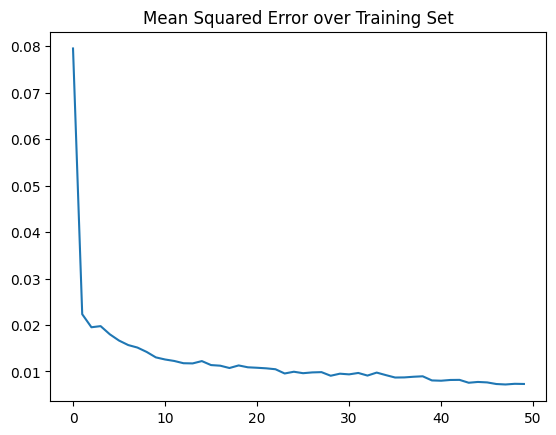

In [44]:
plt.plot(training_model.history['loss'], label = 'Train loss')
plt.title("Mean Squared Error over Training Set")

From the mean squared eroor over training set graph, we can observe a steep decline in MSE during the initial epochs, suggesting that the model rapidly improved its predictions at the start of the training. As the epochs increase, the rate of improvement slows down, and the MSE levels off, indicating that the model has largely stabilized and is making incremental improvements

In [45]:
out_of_sample_forecast_input = np.asarray(out_of_sample_forecast_input).reshape(1, n_steps_in)
out_of_sample_forecast = model.predict(out_of_sample_forecast_input, verbose=0)

list_forecast = scaler.inverse_transform(out_of_sample_forecast).tolist()
aList = [ele for ele in list_forecast[0]]

with open(export_path+"/model1.csv", "w") as f:
    wr = csv.writer(f, delimiter="\n")
    wr.writerow(['Data'])
    wr.writerow(aList)

In [46]:
list_forecast

[[0.032578542828559875,
  0.03160235285758972,
  0.030803794041275978,
  0.03270898014307022,
  0.03056281991302967,
  0.030911704525351524,
  0.029108857735991478,
  0.029044346883893013,
  0.0308355912566185,
  0.029623281210660934,
  0.029168445616960526,
  0.029410986229777336]]

In [47]:
def plotGenerator(model, month):
    latestdata = pd.read_csv(export_path+"/last20data.csv")['Data'].tolist()
    prediction= pd.read_csv(export_path+'model{}.csv'.format(model))['Data'].tolist()[:month]
    prediction.insert(0, latestdata[-1])
    import datetime
    s = '06/2022'

    x1= [datetime.datetime.strptime(s, '%m/%Y') +relativedelta(months=i) for i in range(20)]
    x2= [datetime.datetime.strptime(s, '%m/%Y') + relativedelta(months= 19+ i) for i in range(month+ 1)]
    plt.plot(x1, latestdata, 'r', x2, prediction, 'b--')
    plt.xticks(rotation= 30)
    plt.grid()
    plt.title('Inflation prediction over {} months'.format(month))
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate in %')
    plt.show()
    #plt.savefig(images+'/prediction{}.png'.format(model))
    plt.clf()

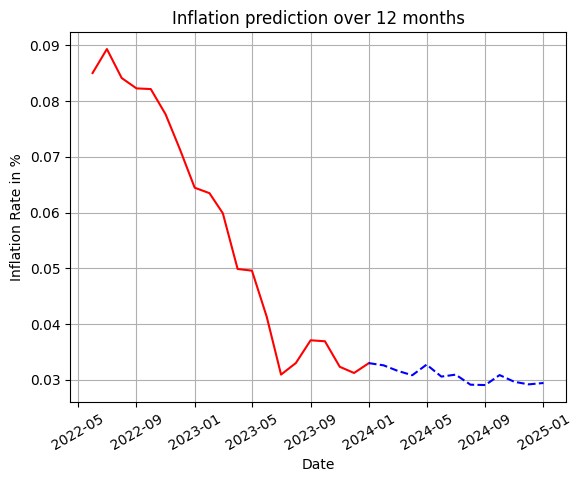

<Figure size 640x480 with 0 Axes>

In [48]:
plotGenerator(1, 12)

The LSTM model seems to predict that after a significant drop, the inflation rate will level out and stabilize under 3% over the course of the forecast period.

It's important to recognize that this model's prediction aligns with the typical goal of the Fed, which target an inflation rate of around 2% as a sign of a healthy economy. The model's projection, which shows inflation approaching but not reaching the 2% mark within the forecast period, might suggest that while the trend is moving in the desired direction, the Federal Reserve's target inflation rate may not be fully achieved before the end of this model's timeframe but this in the case of the full validity of our model.

# Conclusion
The effectiveness of univariate LSTM models in inflation forecasting is limited due to their reliance on historical data. A multivariate LSTM will be challenged in the nex part of our code, where we incorporate various macroeconomic indicators and potentially the model could offer superior predictions by capturing all the macro impact. However, it is important to test and challenge the models against diverse economic scenarios to ensure the robustness.

*Common limitations (risk) of LSTM is that it is easy to overfit and hard to train in a sense that it takes alot of resources (computing power) to train these models fast, requiring memory-bandwidth-bound computation.

## References

| Authors                                             | Year | Title                                                     | Source         | Link                                 |
|-----------------------------------------------------|------|-----------------------------------------------------------|----------------|--------------------------------------|
| Fernandes Theoharidis, A., Guillén, D. A., & Lopes, H. |  2019 | Deep Learning Models For Inflation Forecasting            | Article  | [View Article](https://hedibert.org/wp-content/uploads/2023/03/theoharidis-guillen-lopes-2023.pdf)                 |
| Paranhos, L.                                        | 2023 | Predicting Inflation with Recurrent Neural Networks       | Bank of England | [View Article](https://warwick.ac.uk/fac/soc/economics/staff/lsilvaparanhos/paper_neuralnets.pdf)                  |
|                                         | Year | SUPERVISED MACHINE LEARNING                                                  | smltar.com     | [Deep Learning & LSTM](https://smltar.com/dllstm) |
